In [22]:
import os
import numpy as np
import pandas as pd
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20170605

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

from skimage.transform import resize

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid', {'axes.grid' : False})
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
#sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
import skimage.io  as skio
import glob


In [26]:
"""
Read feature vectors
"""
# --- 
# parameter setup
feature_csv = "/data/put_data/seanyu/ccp/gan_help/gan_pre_flat_output_copper.csv" # features output
image_folder = "/data/put_data/seanyu/ccp/gan_help/gen_image_s_3000_pre/copper/" # image location
csv_copper_meta = "/data/put_data/seanyu/ccp/Copper_meta_revised_0809.csv" # meta-data

is_gan = True
# ---

# read csv files (layer output and meta-data)
V_feature = pd.read_csv(feature_csv, index_col=False)
V_feature['png_name'] = V_feature['png_name'].apply(os.path.basename)
if is_gan:
    pass
else:
    meta = pd.read_csv(csv_copper_meta)

# combine with datetime
if is_gan:
    pass
else:
    V_feature = pd.merge(V_feature, meta[['pid', 'datetime']], how = 'inner', left_on = 'png_name', right_on = 'pid')
    png_time = list(V_feature.datetime)
    png_time_list = []
    for i in png_time:
        png_time_list.append(i.split(" ")[0])

png_seq = list(V_feature.png_name)


In [27]:
# drop it
if is_gan:
    V_feature = V_feature.drop(['Unnamed: 0','png_name'], 1) # drop column: "image"
else:
    V_feature = V_feature.drop(['Unnamed: 0','png_name', 'pid', 'datetime'], 1) # drop column: "image"

#im_path = glob.glob(image_folder + "*.png")
#im_path_basic = [os.path.basename(i) for i in im_path]

im_path = [image_folder + i for i in png_seq]
img = np.array([skio.imread(i) for i in im_path])

In [28]:
vec_proj = TSNE(random_state=RS).fit_transform(V_feature)

In [29]:
vec_proj.astype('float64')

array([[-0.70827488, -0.60852328],
       [-2.71367648,  2.72802273],
       [ 4.40152788,  1.30378236],
       ..., 
       [ 1.19052991, -0.38849009],
       [ 4.40842105,  0.08210924],
       [ 5.56465306,  1.04714381]])

In [20]:
def min_resize(img, size):
    w, h = map(float, img.shape[:,2])
    if min([w, h]) != size:
            if w <= h:
                img = resize(img, (int(round((h/w)*size)), int(size)))
            else:
                img = resize(img, (int(size), int(round((w/h)*size))))
    return img

def img_resize(img, size):
    img = resize(img, (size, size))

def gray_to_color(img):
    if len(img.shape) == 2:
        img = np.dstack([img] * 3)
    return img

def image_scatter(tsne_features, images, res = 1024, cval = 1.):
    # tsne_features: projection of tsne
    # images: np.array list of images (4-D or 3D, N x img_w x img_h) -- in RGB / gray
    # img_res: single image size
    # res: full image res
    # cval: backgroud color value
    tsne_features = tsne_features[:,0:2].astype('float64')
    
    #images = [min_resize(image, img_res) for image in images]
    
    max_width = max([image.shape[0] for image in images])
    max_height = max([image.shape[1] for image in images])
    
    xx = tsne_features[:, 0]
    yy = tsne_features[:, 1]

    x_min, x_max = xx.min(), xx.max()
    y_min, y_max = yy.min(), yy.max()

    sx = (x_max-x_min) # width of canvas
    sy = (y_max-y_min) # height of canvas
    if sx > sy:
        res_x = sx/float(sy)*res
        res_y = res
    else:
        res_x = res
        res_y = sy/float(sx)*res
    print(res_x+max_width, res_y+max_height)
    canvas = np.ones((int(res_x+max_width), int(res_y+max_height), 3))*cval
    x_coords = np.linspace(x_min, x_max, res_x)
    y_coords = np.linspace(y_min, y_max, res_y)

    for x,y,image in zip(xx, yy, images):
        w,h = image.shape[:2]
        x_idx = np.argmin((x - x_coords)**2)
        y_idx = np.argmin((y - y_coords)**2)
        canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image
    return canvas

(20000, 100, 100, 3)

In [ ]:
# print full image
out = image_scatter(vec_proj[0:8000], img[0:8000], res = 6048, cval = 0)
fig = plt.figure(dpi= 400, figsize= (40, 40))
ax = plt.Axes(fig, [0, 0, 1, 1])
ax.set_axis_off()
fig.add_axes(ax)
plt.axis('off')
plt.imshow(out.astype('uint8'))

#sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)
plt.savefig("test1.png")
plt.show()

#plt.plot(vec_proj[:,0], vec_proj[:,1], '.')

6287.41118803 6148


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


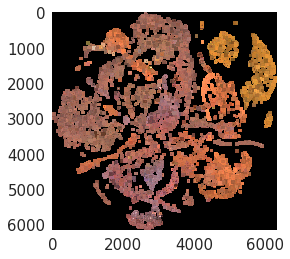

In [52]:
plt.imshow(out.astype('uint8'))
plt.savefig("test1.png")